## Задача: сегментировать клиентскую базу

In [216]:
import pandas as pd
import numpy as np
%matplotlib inline
from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
rcParams['figure.figsize'] = 8, 5


In [217]:
clients = pd.read_excel("Задача.xlsx")
clients.head()

,Персона,"Возраст, лет","Стаж вождения, лет","Убыточность, %","Уровень заработной платы, руб/год"
0,6-LLJEH,20,1,263,716693
1,2-GLHFG,74,51,107,274393
2,6-FJFKL,27,1,165,723841
3,4-KJEJL,24,6,348,139419
4,5-JFFGH,26,3,286,650003


In [218]:
clients.columns

Index(['Персона', 'Возраст, лет', 'Стаж вождения, лет', 'Убыточность, %',
       'Уровень заработной платы, руб/год'],
      dtype='object')

In [219]:
clients.rename(columns = {"Персона" : "person", 
                          "Возраст, лет" : "age",
                          "Стаж вождения, лет" : "dr_exp",
                          "Убыточность, %" : "loss",
                         "Уровень заработной платы, руб/год" : "salary"}, 
              inplace = True)
clients.head()

,person,age,dr_exp,loss,salary
0,6-LLJEH,20,1,263,716693
1,2-GLHFG,74,51,107,274393
2,6-FJFKL,27,1,165,723841
3,4-KJEJL,24,6,348,139419
4,5-JFFGH,26,3,286,650003


In [220]:
clients.describe()

,age,dr_exp,loss,salary
count,484.000000,484.000000,484.000000,4.840000e+02
mean,45.320248,21.417355,227.074380,1.017901e+06
std,19.632512,18.037096,171.561271,1.187545e+06
min,20.000000,1.000000,20.000000,1.201850e+05
25%,26.000000,5.000000,103.000000,1.949980e+05
50%,39.500000,15.000000,173.000000,4.410280e+05
75%,65.000000,38.000000,299.250000,1.109668e+06
max,79.000000,58.000000,700.000000,3.982828e+06


In [221]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 5 columns):
person    484 non-null object
age       484 non-null int64
dr_exp    484 non-null int64
loss      484 non-null int64
salary    484 non-null int64
dtypes: int64(4), object(1)
memory usage: 19.0+ KB


### Все признаки, кроме person количественные. Посмотрим на  их распределения

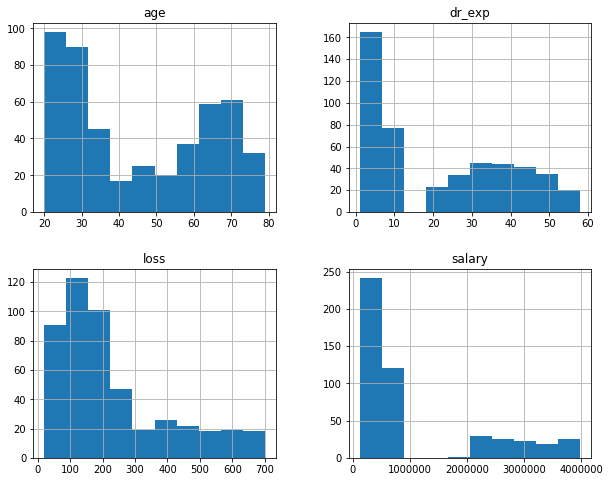

In [222]:
clients[clients.columns[1:]].hist(figsize = (10, 8));

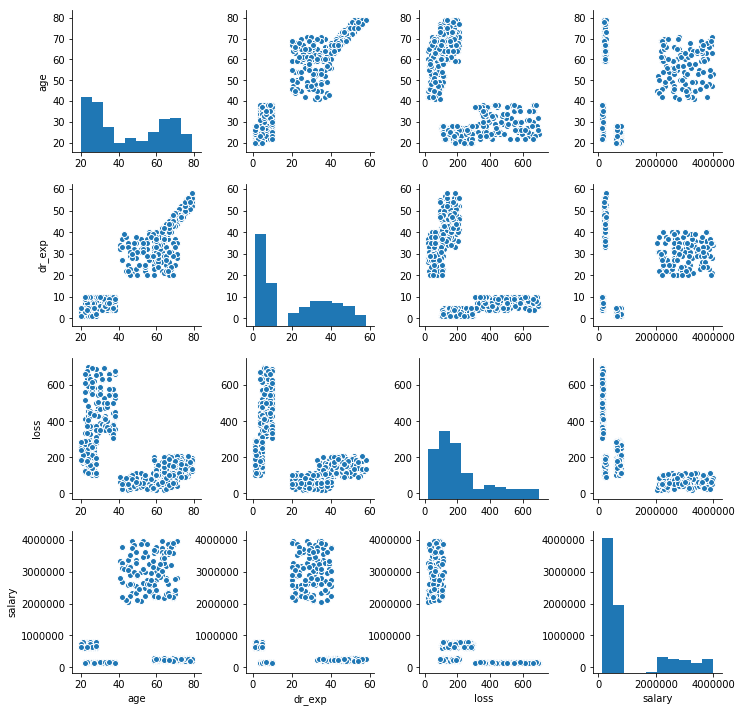

In [223]:
sns.pairplot(clients.iloc[:, 1:]);

In [224]:
clients.corr() # очень сильная корреляция между возрастом и опытом вождения, что ожидаемо

,age,dr_exp,loss,salary
age,1.000000,0.944395,-0.535885,0.255785
dr_exp,0.944395,1.000000,-0.516287,0.190904
loss,-0.535885,-0.516287,1.000000,-0.583522
salary,0.255785,0.190904,-0.583522,1.000000


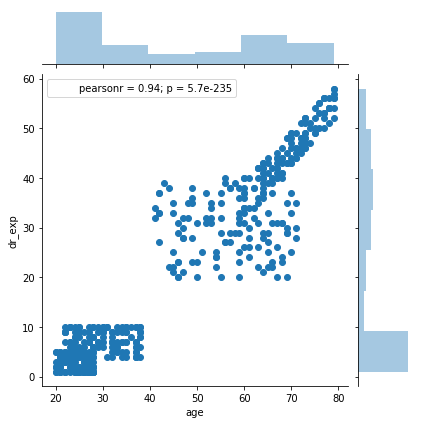

In [225]:
sns.jointplot("age", "dr_exp", data = clients);

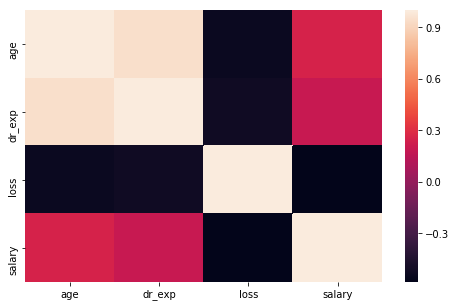

In [226]:
sns.heatmap(clients.corr())

### Попробуем визуализировать наши данные в двумерном пространстве. Возможно удастся увидеть какую-то структуру или потенциальное количество кластеров. Для этого используем алгоритм t-SNE

In [227]:
from sklearn.manifold import TSNE

Wall time: 13.7 s


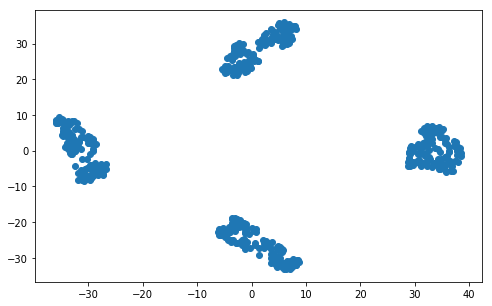

In [228]:
%%time
X = clients.drop('person', axis = 1) # избавимся от неколичественных признаков
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) # задействуем метод fit_transform() класса StandardScaler для 
# масштабирование данных


tsne = TSNE()
tsne_repr = tsne.fit_transform(X_scaled)

# Отрисовываем scatter plot для отображения данных в двухмерном пространстве
plt.scatter(tsne_repr[:,0], tsne_repr[:,1]); # tsne показывает четкое разбиение данных на 4 кластера

### Воспользуемся тремя алгоритмами кластеризации, разбивая данные на 4 кластера, а затем сравним и результаты их работы графически

### 1) Метод k - средних (k-means)

### Сначала посмотрим какое оптимальное число кластеров предполагается для метода KMeans

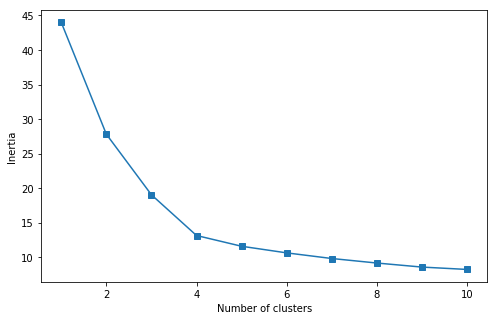

In [229]:
from sklearn.cluster import KMeans
inertia = [] 
for e in range(1, 11):
    kmeans = KMeans(n_clusters = e).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_)) # inertia - это сумма квадратов расстояний от точек до центройдов
    
plt.plot(range(1, 11), inertia, marker='s');
plt.xlabel('Number of clusters');
plt.ylabel('Inertia');

# По графика видно, что сумма квадратов расстояний от точек до центроидов уменьшается уже не так сильно после 4 кластера

In [230]:
kmeans = KMeans(n_clusters = 4, n_init=1000).fit(X_scaled)
# Добавим номера кластеров по версии k-means в таблицу
clients['kmeans_cluster'] = kmeans.labels_
clients.head()

,person,age,dr_exp,loss,salary,kmeans_cluster
0,6-LLJEH,20,1,263,716693,1
1,2-GLHFG,74,51,107,274393,2
2,6-FJFKL,27,1,165,723841,1
3,4-KJEJL,24,6,348,139419,3
4,5-JFFGH,26,3,286,650003,1


### Будем нумеровать кластеры от 1

In [231]:
clients['kmeans_cluster'] = clients['kmeans_cluster'].apply(lambda cluster: cluster + 1)
clients.head()

,person,age,dr_exp,loss,salary,kmeans_cluster
0,6-LLJEH,20,1,263,716693,2
1,2-GLHFG,74,51,107,274393,3
2,6-FJFKL,27,1,165,723841,2
3,4-KJEJL,24,6,348,139419,4
4,5-JFFGH,26,3,286,650003,2


### Метод DBSCAN

In [232]:
from sklearn.cluster import DBSCAN

db = DBSCAN().fit(X_scaled)

clients['dbscan_cluster'] = db.labels_
clients['dbscan_cluster'] = clients['dbscan_cluster'].apply(lambda cluster: cluster + 1)
clients['dbscan_cluster'].value_counts() # dbscan автоматические разбил данные только на 3 кластера

1    242
3    121
2    121
Name: dbscan_cluster, dtype: int64

### Агломеративная кластеризация

### Сначала построим дендрограмму

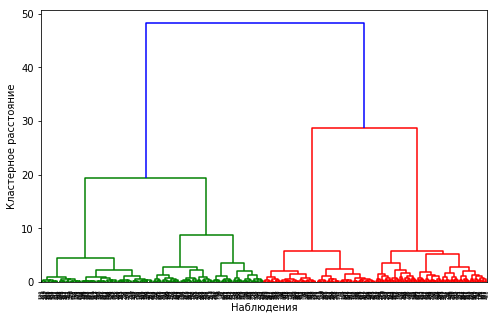

In [233]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(X_scaled)
dendrogram(linkage_array)
ax = plt.gca() # индексы наблюдений смазались, т.к. их было слишком много, но в данном случае это не критично
plt.xlabel("Наблюдения");
plt.ylabel("Кластерное расстояние");

In [234]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 4)
agg.fit_predict(X_scaled)
clients['agg_cluster'] = agg.labels_
clients['agg_cluster'] = clients['agg_cluster'].apply(lambda cluster: cluster + 1)
clients.head()

,person,age,dr_exp,loss,salary,kmeans_cluster,dbscan_cluster,agg_cluster
0,6-LLJEH,20,1,263,716693,2,1,4
1,2-GLHFG,74,51,107,274393,3,2,3
2,6-FJFKL,27,1,165,723841,2,1,4
3,4-KJEJL,24,6,348,139419,4,1,1
4,5-JFFGH,26,3,286,650003,2,1,4


### Посмотрим на результат работы k-means графически

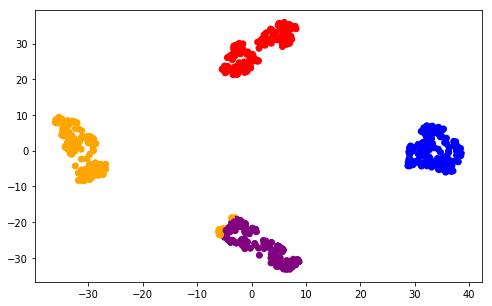

In [235]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
            c = clients['kmeans_cluster'].map({1: 'blue', 2: 'orange', 3: 'red', 4: 'purple'})); # часть фиолетового кластера 
# по k-means почему то принадлежит желтому 

### Результаты работы DBSCAN

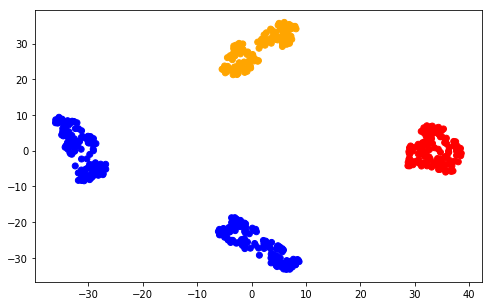

In [236]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
            c = clients['dbscan_cluster'].map({1: 'blue', 2: 'orange', 3: 'red'}));
# 2 кластера почему то объединены и обозначены как 1

### Результаты работы агломеративной кластеризации

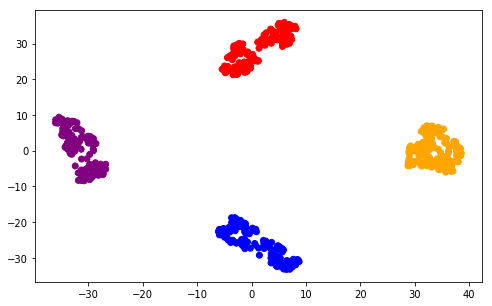

In [237]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], 
            c = clients['agg_cluster'].map({1: 'blue', 2: 'orange', 3: 'red', 4: 'purple'}));
# отличное разбиение

### Графически самое лучшее разбиение показал алгоритм агломеративной кластеризации. Посмотрим на статистики по кластерам, получившимся по этому методу.

In [238]:
clients['agg_cluster'].value_counts() 

4    121
3    121
2    121
1    121
Name: agg_cluster, dtype: int64

In [239]:
clients.groupby(['agg_cluster'])['age', 'dr_exp', 'loss', 'salary'].agg([np.mean, np.median, np.std, np.min, np.max])

age                                dr_exp                   \
                  mean median       std amin amax       mean median       std   
agg_cluster                                                                     
1            30.107438     30  5.115013   22   38   7.322314      7  2.021612   
2            56.818182     57  8.721621   41   71  29.933884     30  5.832003   
3            69.851240     70  5.687210   59   79  45.826446     46  6.113752   
4            24.504132     25  2.536809   20   28   2.586777      2  1.492590   

                             loss                                     salary  \
            amin amax        mean median         std amin amax          mean   
agg_cluster                                                                    
1              4   10  487.140496    471  112.865651  306  700  1.494616e+05   
2             20   40   65.752066     62   25.988549   20  116  2.978736e+06   
3             33   58  152.380165    153   32.875334   92  209  2.429584e+05   
4              1    5  203.024793    196   57.666059  101  297  7.004473e+05   

                                                       
              median            std     amin     amax  
agg_cluster                                            
1             148751   17327.340695   120185   179863  
2            2911694  572371.806138  2040290  3982828  
3             243203   24325.309127   200043   279472  
4             692754   57143.673294   602584   799461

### Для более удобного сравнения по кластерам используем сводную таблицу

In [240]:
clients.pivot_table(['age',
                    'dr_exp',
                    'loss',
                    'salary'], ['agg_cluster'],
                   aggfunc = [np.mean, np.std, np.median, np.max])

mean                                            std  \
                   age     dr_exp        loss        salary       age   
agg_cluster                                                             
1            30.107438   7.322314  487.140496  1.494616e+05  5.115013   
2            56.818182  29.933884   65.752066  2.978736e+06  8.721621   
3            69.851240  45.826446  152.380165  2.429584e+05  5.687210   
4            24.504132   2.586777  203.024793  7.004473e+05  2.536809   

                                                 median                       \
               dr_exp        loss         salary    age dr_exp loss   salary   
agg_cluster                                                                    
1            2.021612  112.865651   17327.340695     30      7  471   148751   
2            5.832003   25.988549  572371.806138     57     30   62  2911694   
3            6.113752   32.875334   24325.309127     70     46  153   243203   
4            1.492590   57.666059   57143.673294     25      2  196   692754   

            amax                       
             age dr_exp loss   salary  
agg_cluster                            
1             38     10  700   179863  
2             71     40  116  3982828  
3             79     58  209   279472  
4             28      5  297   799461

### Рассмотрим также статистики для кластеров, образованных в результате применения других методов

### k-means

In [241]:
clients['kmeans_cluster'].value_counts()

2    128
3    121
1    121
4    114
Name: kmeans_cluster, dtype: int64

In [242]:
clients.groupby(['kmeans_cluster'])['age', 'dr_exp', 'loss', 'salary'].agg([np.mean, np.median, np.std, np.min, np.max])

age                                dr_exp         \
                     mean median       std amin amax       mean median   
kmeans_cluster                                                           
1               56.818182     57  8.721621   41   71  29.933884     30   
2               24.734375     25  2.968295   20   37   2.835938      2   
3               69.851240     70  5.687210   59   79  45.826446     46   
4               30.192982     30  5.062227   22   38   7.333333      7   

                                          loss                               \
                     std amin amax        mean median         std amin amax   
kmeans_cluster                                                                
1               5.832003   20   40   65.752066     62   25.988549   20  116   
2               1.851908    1   10  209.640625    199   62.542047  101  337   
3               6.113752   33   58  152.380165    153   32.875334   92  209   
4               2.016159    4   10  497.157895    484  108.490086  330  700   

                      salary                                            
                        mean   median            std     amin     amax  
kmeans_cluster                                                          
1               2.978736e+06  2911694  572371.806138  2040290  3982828  
2               6.704663e+05   689903  136937.394775   139104   799461  
3               2.429584e+05   243203   24325.309127   200043   279472  
4               1.492920e+05   148532   17630.238108   120185   179863

In [243]:
clients.pivot_table(['age',
                    'dr_exp',
                    'loss',
                    'salary'], ['kmeans_cluster'],
                   aggfunc = [np.mean, np.std, np.median, np.max])

mean                                            std  \
                      age     dr_exp        loss        salary       age   
kmeans_cluster                                                             
1               56.818182  29.933884   65.752066  2.978736e+06  8.721621   
2               24.734375   2.835938  209.640625  6.704663e+05  2.968295   
3               69.851240  45.826446  152.380165  2.429584e+05  5.687210   
4               30.192982   7.333333  497.157895  1.492920e+05  5.062227   

                                                    median              \
                  dr_exp        loss         salary    age dr_exp loss   
kmeans_cluster                                                           
1               5.832003   25.988549  572371.806138     57     30   62   
2               1.851908   62.542047  136937.394775     25      2  199   
3               6.113752   32.875334   24325.309127     70     46  153   
4               2.016159  108.490086   17630.238108     30      7  484   

                        amax                       
                 salary  age dr_exp loss   salary  
kmeans_cluster                                     
1               2911694   71     40  116  3982828  
2                689903   37     10  337   799461  
3                243203   79     58  209   279472  
4                148532   38     10  700   179863

### DBSCAN

In [244]:
clients['dbscan_cluster'].value_counts()

1    242
3    121
2    121
Name: dbscan_cluster, dtype: int64

In [245]:
clients.groupby(['dbscan_cluster'])['age', 'dr_exp', 'loss', 'salary'].agg([np.mean, np.median, np.std, np.min, np.max])

age                                dr_exp         \
                     mean median       std amin amax       mean median   
dbscan_cluster                                                           
1               27.305785     26  4.910558   20   38   4.954545      5   
2               69.851240     70  5.687210   59   79  45.826446     46   
3               56.818182     57  8.721621   41   71  29.933884     30   

                                          loss                               \
                     std amin amax        mean median         std amin amax   
dbscan_cluster                                                                
1               2.962070    1   10  345.082645  301.5  168.115604  101  700   
2               6.113752   33   58  152.380165  153.0   32.875334   92  209   
3               5.832003   20   40   65.752066   62.0   25.988549   20  116   

                      salary                                              
                        mean     median            std     amin     amax  
dbscan_cluster                                                            
1               4.249545e+05   391223.5  279260.886246   120185   799461  
2               2.429584e+05   243203.0   24325.309127   200043   279472  
3               2.978736e+06  2911694.0  572371.806138  2040290  3982828

In [246]:
clients.pivot_table(['age',
                    'dr_exp',
                    'loss',
                    'salary'], ['dbscan_cluster'],
                   aggfunc = [np.mean, np.std, np.median, np.max])

mean                                            std  \
                      age     dr_exp        loss        salary       age   
dbscan_cluster                                                             
1               27.305785   4.954545  345.082645  4.249545e+05  4.910558   
2               69.851240  45.826446  152.380165  2.429584e+05  5.687210   
3               56.818182  29.933884   65.752066  2.978736e+06  8.721621   

                                                    median                \
                  dr_exp        loss         salary    age dr_exp   loss   
dbscan_cluster                                                             
1               2.962070  168.115604  279260.886246   26.0    5.0  301.5   
2               6.113752   32.875334   24325.309127   70.0   46.0  153.0   
3               5.832003   25.988549  572371.806138   57.0   30.0   62.0   

                          amax                       
                   salary  age dr_exp loss   salary  
dbscan_cluster                                       
1                391223.5   38     10  700   799461  
2                243203.0   79     58  209   279472  
3               2911694.0   71     40  116  3982828

### Оценим также результаты работы алгоритмов кластеризации при помощи анализа главных компонент и визуализации его результатов.

In [247]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_) # объясняем около 90 % дисперсии при помощи 2 новых осей
X_pca = pca.transform(X_scaled)


[ 0.64041496  0.26181602]


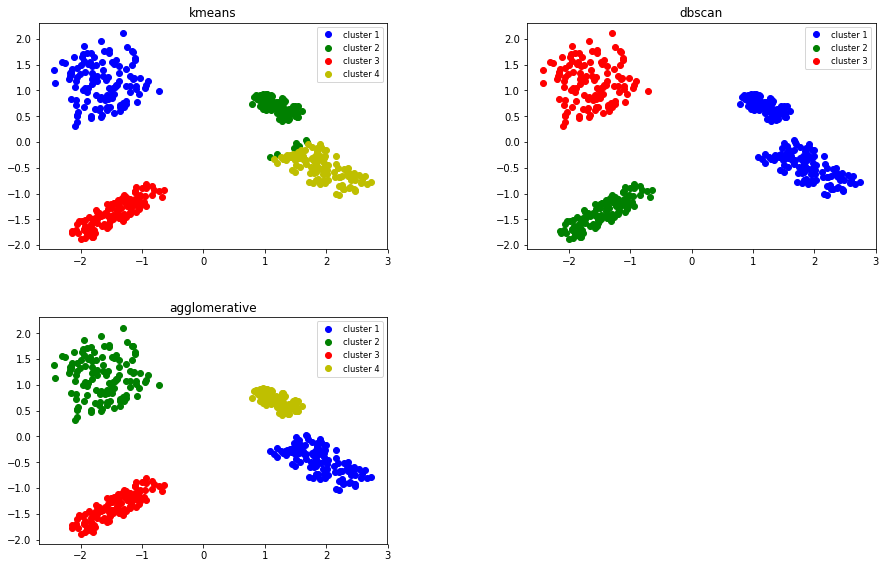

In [249]:
y1 = np.array(clients['kmeans_cluster'])
y2 = np.array(clients['dbscan_cluster'])
y3 = np.array(clients['agg_cluster'])



plt.figure(figsize = (15, 15))





plt.subplot(3, 2, 1)
plt.plot(X_pca[y1 == 1, 0], X_pca[y1 == 1, 1], 'bo', label='cluster 1')
plt.plot(X_pca[y1 == 2, 0], X_pca[y1 == 2, 1], 'go', label='cluster 2')
plt.plot(X_pca[y1 == 3, 0], X_pca[y1 == 3, 1], 'ro', label='cluster 3')
plt.plot(X_pca[y1 == 4, 0], X_pca[y1 == 4, 1], 'yo', label='cluster 4')

plt.title("kmeans");
plt.legend(loc = 1, fontsize = 'small');

plt.subplot(3, 2, 2)
plt.plot(X_pca[y2 == 1, 0], X_pca[y2 == 1, 1], 'bo', label='cluster 1')
plt.plot(X_pca[y2 == 2, 0], X_pca[y2 == 2, 1], 'go', label='cluster 2')
plt.plot(X_pca[y2 == 3, 0], X_pca[y2 == 3, 1], 'ro', label='cluster 3')

plt.title("dbscan")
plt.legend(loc = 1, fontsize = 'small');

plt.subplot(3, 2, 3)
plt.plot(X_pca[y3 == 1, 0], X_pca[y3 == 1, 1], 'bo', label='cluster 1')
plt.plot(X_pca[y3 == 2, 0], X_pca[y3 == 2, 1], 'go', label='cluster 2')
plt.plot(X_pca[y3 == 3, 0], X_pca[y3 == 3, 1], 'ro', label='cluster 3')
plt.plot(X_pca[y3 == 4, 0], X_pca[y3 == 4, 1], 'yo', label='cluster 4')

plt.title("agglomerative")
plt.legend(loc = 1, fontsize = 'small');



plt.subplots_adjust(wspace = 0.4, hspace = 0.3) 


### По графику видно, что агломеративный метод кластеризации разделил две отностильно близкие группы людей, в том время как плотностный алгоритм кластеризации посчитал их одним кластером

### Таким образом, результат агломеративной кластеризации, по моему мнению, наиболее оптимальный. Выведем еще раз статистики для кластеров, полученных путем применения агломеративного метода

In [250]:
clients.groupby(['agg_cluster'])['age', 'dr_exp', 'loss', 'salary'].agg([np.mean, np.median, np.std, np.min, np.max])

age                                dr_exp                   \
                  mean median       std amin amax       mean median       std   
agg_cluster                                                                     
1            30.107438     30  5.115013   22   38   7.322314      7  2.021612   
2            56.818182     57  8.721621   41   71  29.933884     30  5.832003   
3            69.851240     70  5.687210   59   79  45.826446     46  6.113752   
4            24.504132     25  2.536809   20   28   2.586777      2  1.492590   

                             loss                                     salary  \
            amin amax        mean median         std amin amax          mean   
agg_cluster                                                                    
1              4   10  487.140496    471  112.865651  306  700  1.494616e+05   
2             20   40   65.752066     62   25.988549   20  116  2.978736e+06   
3             33   58  152.380165    153   32.875334   92  209  2.429584e+05   
4              1    5  203.024793    196   57.666059  101  297  7.004473e+05   

                                                       
              median            std     amin     amax  
agg_cluster                                            
1             148751   17327.340695   120185   179863  
2            2911694  572371.806138  2040290  3982828  
3             243203   24325.309127   200043   279472  
4             692754   57143.673294   602584   799461

In [251]:
clients.pivot_table(['age',
                    'dr_exp',
                    'loss',
                    'salary'], ['agg_cluster'],
                   aggfunc = [np.mean, np.std, np.median, np.max])

mean                                            std  \
                   age     dr_exp        loss        salary       age   
agg_cluster                                                             
1            30.107438   7.322314  487.140496  1.494616e+05  5.115013   
2            56.818182  29.933884   65.752066  2.978736e+06  8.721621   
3            69.851240  45.826446  152.380165  2.429584e+05  5.687210   
4            24.504132   2.586777  203.024793  7.004473e+05  2.536809   

                                                 median                       \
               dr_exp        loss         salary    age dr_exp loss   salary   
agg_cluster                                                                    
1            2.021612  112.865651   17327.340695     30      7  471   148751   
2            5.832003   25.988549  572371.806138     57     30   62  2911694   
3            6.113752   32.875334   24325.309127     70     46  153   243203   
4            1.492590   57.666059   57143.673294     25      2  196   692754   

            amax                       
             age dr_exp loss   salary  
agg_cluster                            
1             38     10  700   179863  
2             71     40  116  3982828  
3             79     58  209   279472  
4             28      5  297   799461